# Machine Learning–Based Network Intrusion Detection System (NIDS)

**Course:** Introduction to Data Mining  
**Student:** Md Shariful Islam  
**UNBC ID:** 230168914  

This notebook follows the project proposal:

- Use CIC-IDS-2017 (multiple days/files) to build a Network Intrusion Detection System
- Apply data cleaning, EDA, feature selection (RFE, tree-based importance)
- Train multiple ML models (LR, KNN, DT, RF, XGBoost, LightGBM, AdaBoost, CatBoost, Voting)
- Evaluate using Accuracy, Precision, Recall, F1-score, and confusion matrices
- Compare single vs ensemble models and analyze important features.


## 1. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# Optional gradient boosting libraries
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None

try:
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = None

try:
    from catboost import CatBoostClassifier
except ImportError:
    CatBoostClassifier = None

sns.set(style="whitegrid")

## 2. Load & Merge CIC-IDS-2017 CSV Files

Update the paths below to match where you stored the CIC-IDS-2017 CSVs.

Suggested files:
- `Monday-WorkingHours.pcap_ISCX.csv` (mostly BENIGN)
- `Wednesday-workingHours.pcap_ISCX.csv` (mixed)
- `Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv`
- `Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv`

In [3]:
# TODO: adjust these paths to your local data directory
files = [
    "/content/data/Monday-WorkingHours.pcap_ISCX.csv",
    "/content/data/Wednesday-workingHours.pcap_ISCX.csv",
    "/content/data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "/content/data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
]
files

['/content/data/Monday-WorkingHours.pcap_ISCX.csv',
 '/content/data/Wednesday-workingHours.pcap_ISCX.csv',
 '/content/data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 '/content/data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']

In [4]:
def load_cic_file(path: str) -> pd.DataFrame:
    """Load a CIC-IDS-2017 CSV and normalize column names."""
    df = pd.read_csv(path)
    # strip spaces from column names
    df.columns = df.columns.str.strip()
    return df

dfs = []
for f in files:
    print("Loading:", f)
    df_tmp = load_cic_file(f)
    print("  Shape:", df_tmp.shape)
    dfs.append(df_tmp)

len(dfs)

Loading: /content/data/Monday-WorkingHours.pcap_ISCX.csv
  Shape: (529918, 79)
Loading: /content/data/Wednesday-workingHours.pcap_ISCX.csv
  Shape: (692703, 79)
Loading: /content/data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  Shape: (286467, 79)
Loading: /content/data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  Shape: (225745, 79)


4

### 2.1 Align columns and concatenate

I only keep the columns that are common across all selected files (including `Label`).

In [5]:
# Find common columns across all dataframes
common_cols = set(dfs[0].columns)
for d in dfs[1:]:
    common_cols = common_cols.intersection(set(d.columns))

common_cols = sorted(list(common_cols))
print("Number of common columns:", len(common_cols))
print("Sample common columns:", common_cols[:20])

# Keep only common columns and concatenate
dfs_common = [d[common_cols].copy() for d in dfs]
df_full = pd.concat(dfs_common, axis=0, ignore_index=True)
print("Merged shape:", df_full.shape)
df_full.head()

Number of common columns: 79
Sample common columns: ['ACK Flag Count', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Header Length', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Total', 'Bwd PSH Flags', 'Bwd Packet Length Max', 'Bwd Packet Length Mean']
Merged shape: (1734833, 79)


,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,...,Subflow Bwd Packets,Subflow Fwd Bytes,Subflow Fwd Packets,Total Backward Packets,Total Fwd Packets,Total Length of Bwd Packets,Total Length of Fwd Packets,URG Flag Count,act_data_pkt_fwd,min_seg_size_forward
0,1,0,0.0,0,0.0,9.0,0.0,6.0,0,0,...,0,12,2,0,2,0,12,1,1,20
1,1,0,0.0,0,0.0,9.0,0.0,6.0,0,0,...,0,12,2,0,2,0,12,1,1,20
2,1,0,0.0,0,0.0,9.0,0.0,6.0,0,0,...,0,12,2,0,2,0,12,1,1,20
3,1,0,0.0,0,0.0,9.0,0.0,6.0,0,0,...,0,12,2,0,2,0,12,1,1,20
4,1,0,0.0,0,0.0,9.0,0.0,6.0,0,0,...,0,12,2,0,2,0,12,1,1,20


## 3. Data Cleaning & Label Normalization

As per the proposal:
- Remove NaNs, infinities, and duplicates
- Normalize the label into a binary target: BENIGN vs ATTACK.

In [6]:
df = df_full.copy()

# replace infinities with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# drop rows with NaN values
df = df.dropna()

# drop duplicate rows
df = df.drop_duplicates()

df=df.sample(frac=0.50, random_state=52)

print("After cleaning:", df.shape)
df.head()

After cleaning: (770852, 79)


,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,...,Subflow Bwd Packets,Subflow Fwd Bytes,Subflow Fwd Packets,Total Backward Packets,Total Fwd Packets,Total Length of Bwd Packets,Total Length of Fwd Packets,URG Flag Count,act_data_pkt_fwd,min_seg_size_forward
91437,1,53514,53482.333333,53461,27.970222,10.625,12.2,6.0,0,0,...,5,18,3,5,3,61,18,0,2,20
50074,0,0,0.000000,0,0.000000,91.000,82.0,50.0,0,0,...,1,50,1,1,1,82,50,0,0,40
1324710,0,0,0.000000,0,0.000000,5.000,6.0,2.0,0,0,...,1,2,1,1,1,6,2,0,0,24
1303238,1,0,0.000000,0,0.000000,9.000,6.0,6.0,0,0,...,1,6,1,1,1,6,6,1,0,20
485768,0,0,0.000000,0,0.000000,100.500,147.0,36.0,0,0,...,2,72,2,2,2,294,72,0,1,32


In [7]:
# inspect label values
df['Label'] = df['Label'].astype(str).str.strip()
df['Label'].value_counts()

,count
Label,
BENIGN,564462
DoS Hulk,86347
DDoS,64250
PortScan,45303
DoS GoldenEye,5177
DoS slowloris,2695
DoS Slowhttptest,2609
Heartbleed,9


In [8]:
# map to binary: 0 = BENIGN, 1 = any ATTACK
def map_binary(label: str) -> int:
    label = str(label).upper()
    if "BENIGN" in label:
        return 0
    else:
        return 1

df['Attack_Binary'] = df['Label'].apply(map_binary)
df['Attack_Binary'].value_counts()

,count
Attack_Binary,
0,564462
1,206390


## 4. Exploratory Data Analysis (EDA)

- Class distribution
- Summary statistics
- Correlation heatmap (for a subset of features).

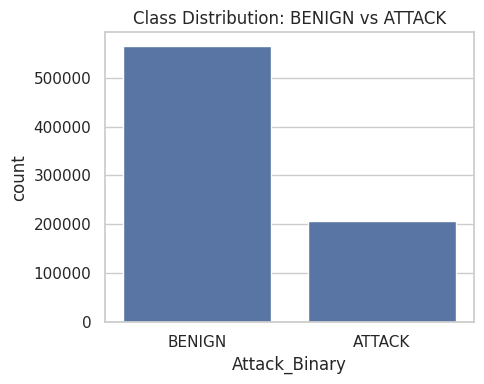

In [9]:
# Class distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='Attack_Binary', data=df)
plt.xticks([0, 1], ['BENIGN', 'ATTACK'])
plt.title('Class Distribution: BENIGN vs ATTACK')
plt.tight_layout()
plt.show()

In [10]:
# Basic numeric summary
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].describe().T.head(20)

,count,mean,std,min,25%,50%,75%,max
ACK Flag Count,770852.0,3.396631e-01,4.735952e-01,0.0,0.0,0.0,1.000000,1.000000e+00
Active Max,770852.0,1.691655e+05,1.080615e+06,0.0,0.0,0.0,5.000000,1.020000e+08
Active Mean,770852.0,9.837821e+04,6.885956e+05,0.0,0.0,0.0,5.000000,1.016597e+08
Active Min,770852.0,7.295578e+04,6.039964e+05,0.0,0.0,0.0,4.000000,1.016597e+08
Active Std,770852.0,4.321898e+04,4.381006e+05,0.0,0.0,0.0,0.000000,7.050000e+07
Average Packet Size,770852.0,2.696528e+02,4.047615e+02,0.0,9.0,84.5,284.541154,2.528000e+03
Avg Bwd Segment Size,770852.0,4.471654e+02,7.530870e+02,0.0,6.0,92.0,373.400000,5.800500e+03
Avg Fwd Segment Size,770852.0,7.207223e+01,2.319496e+02,0.0,6.0,36.0,53.500000,4.141771e+03
Bwd Avg Bulk Rate,770852.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00
Bwd Avg Bytes/Bulk,770852.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00


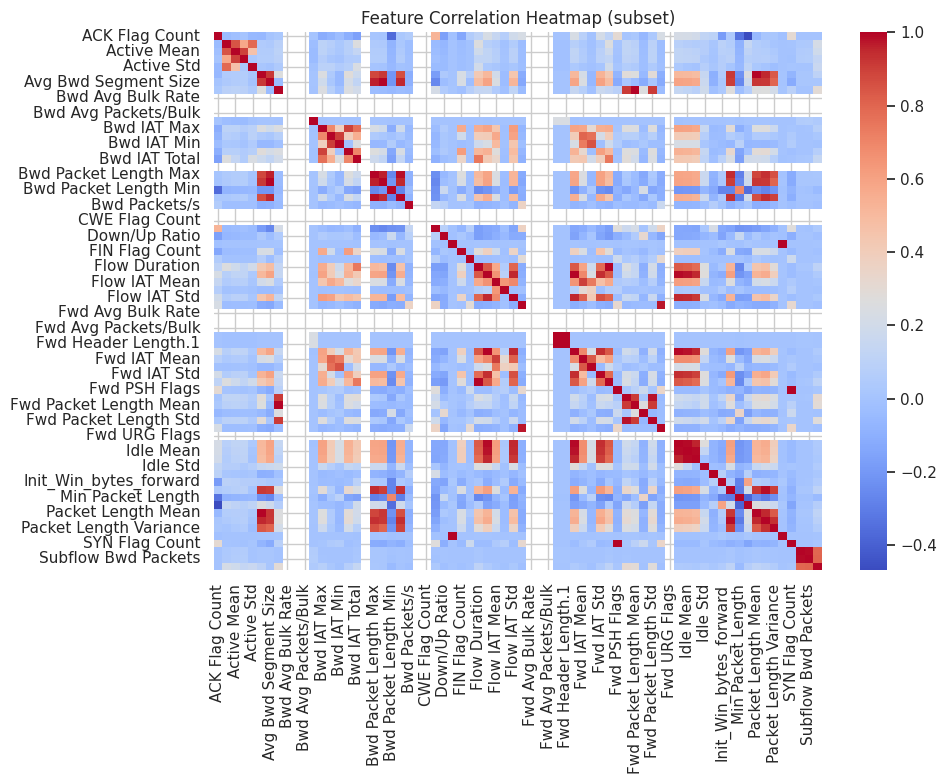

In [11]:
# Correlation heatmap on a subset of features (to keep it readable)
corr_cols = [c for c in numeric_cols if c != 'Attack_Binary']

# If there are many features, sample a subset for visualization
max_corr_features = 70
corr_sample_cols = corr_cols[:max_corr_features]

corr = df[corr_sample_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', square=False, cbar=True)
plt.title('Feature Correlation Heatmap (subset)')
plt.tight_layout()
plt.show()

In [12]:
# Keep only upper triangle of the correlation matrix
upper = np.triu(np.ones(corr.shape), k=1).astype(bool)
upper_corr = corr.where(upper)

# Threshold for "too highly correlated"
threshold = 0.90

# Find columns to drop
to_drop = [
    column for column in corr.columns
    if any(upper_corr[column] > threshold)
]

print("Highly correlated features to drop (>", threshold, "):")
for col in to_drop:
    print("-", col)

# Drop redundant features
df_filtered = df.drop(columns=to_drop)
filtered_feature_cols = [c for c in df_filtered.columns if c != 'la']

print("\nNumber of original features:", len(corr_sample_cols))
print("Number of features after correlation filter:", len(filtered_feature_cols))

Highly correlated features to drop (> 0.9 ):
- Avg Bwd Segment Size
- Bwd IAT Min
- Bwd Packet Length Max
- Bwd Packet Length Mean
- Bwd Packet Length Std
- Flow IAT Std
- Fwd Header Length.1
- Fwd IAT Max
- Fwd IAT Std
- Fwd IAT Total
- Fwd Packet Length Max
- Fwd Packet Length Mean
- Fwd Packet Length Std
- Fwd Packets/s
- Idle Max
- Idle Mean
- Idle Min
- Max Packet Length
- Packet Length Mean
- Packet Length Std
- Packet Length Variance
- RST Flag Count
- SYN Flag Count
- Subflow Bwd Packets

Number of original features: 70
Number of features after correlation filter: 56


## 5. Feature Selection & Train/Test Split

We follow the proposal:
- Use numeric features as input (excluding the binary label)
- Split into train/test sets
- Standardize features
- Apply RFE with RandomForest to select top features.

In [13]:
# Define input features and target
feature_cols = [c for c in numeric_cols if c != 'Attack_Binary']
print (feature_cols)
print("Number of features:", len(feature_cols))

filtered_feature_cols = [
    c for c in filtered_feature_cols
    if c not in ['Label', 'Attack_Binary']
]

print (filtered_feature_cols)
print ("Number of filtered features: ", len(filtered_feature_cols))

X = df[filtered_feature_cols].values
y = df['Attack_Binary'].values

['ACK Flag Count', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Header Length', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Total', 'Bwd PSH Flags', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Bwd Packets/s', 'Bwd URG Flags', 'CWE Flag Count', 'Destination Port', 'Down/Up Ratio', 'ECE Flag Count', 'FIN Flag Count', 'Flow Bytes/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s', 'Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Header Length', 'Fwd Header Length.1', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd PSH Flags', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Fwd Packets/s', 'Fwd

In [14]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((539596, 54), (231256, 54))

In [ ]:
from sklearn.feature_selection import RFE

rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfe = RFE(estimator=rf_for_rfe, n_features_to_select=30, step=1)

rfe.fit(X_train_scaled, y_train)

selected_mask = rfe.support_
selected_features = [f for f, m in zip(feature_cols, selected_mask) if m]

print("Selected features (RFE, top 30):")
for f in selected_features:
    print("-", f)

X_train_sel = X_train_scaled[:, selected_mask]
X_test_sel = X_test_scaled[:, selected_mask]
X_train_sel.shape, X_test_sel.shape

## 6. Model Implementation & Evaluation

We now train multiple models:

- Logistic Regression  
- K-Nearest Neighbors
- Support Vector Machine
- Naive Bayes
- Decision Tree  
- Random Forest  
- Gradient Boosting  
- XGBoost (if installed)  
- LightGBM (if installed)  
- AdaBoost  
- CatBoost (if installed)  

We will then compare performance metrics and confusion matrices.

In [ ]:
models = {}

models["LogisticRegression"] = LogisticRegression(max_iter=1000, n_jobs=-1)
models["KNN"] = KNeighborsClassifier(n_neighbors=5)
models["DecisionTree"] = DecisionTreeClassifier(random_state=42)
models["RandomForest"] = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
models["GradientBoosting"] = GradientBoostingClassifier(random_state=42)
models["AdaBoost"] = AdaBoostClassifier(random_state=42)
models["SVM"] = SVC(kernel="rbf", probability=True, random_state=42)
models["NaiveBayes"] = GaussianNB()

if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )

if LGBMClassifier is not None:
    models["LightGBM"] = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42,
    )

if CatBoostClassifier is not None:
    models["CatBoost"] = CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        verbose=False,
        random_state=42,
    )

list(models.keys())

['LogisticRegression',
 'KNN',
 'DecisionTree',
 'RandomForest',
 'GradientBoosting',
 'AdaBoost',
 'SVM',
 'NaiveBayes']


=== LogisticRegression ===
              precision    recall  f1-score   support

      BENIGN       0.96      0.96      0.96    169339
      ATTACK       0.88      0.89      0.88     61917

    accuracy                           0.94    231256
   macro avg       0.92      0.92      0.92    231256
weighted avg       0.94      0.94      0.94    231256



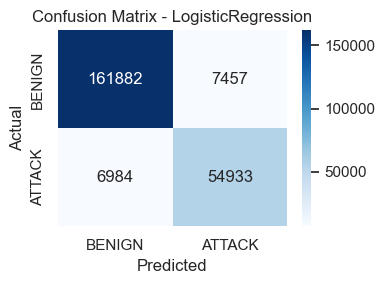


=== KNN ===
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    169339
      ATTACK       1.00      1.00      1.00     61917

    accuracy                           1.00    231256
   macro avg       1.00      1.00      1.00    231256
weighted avg       1.00      1.00      1.00    231256



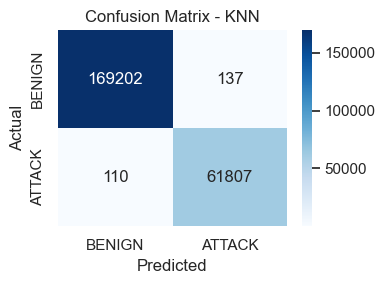


=== DecisionTree ===
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    169339
      ATTACK       1.00      1.00      1.00     61917

    accuracy                           1.00    231256
   macro avg       1.00      1.00      1.00    231256
weighted avg       1.00      1.00      1.00    231256



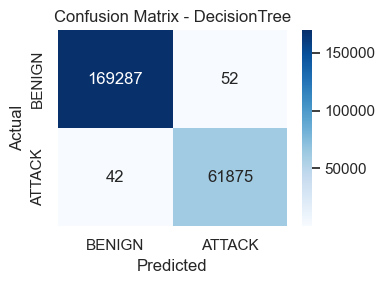


=== RandomForest ===
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    169339
      ATTACK       1.00      1.00      1.00     61917

    accuracy                           1.00    231256
   macro avg       1.00      1.00      1.00    231256
weighted avg       1.00      1.00      1.00    231256



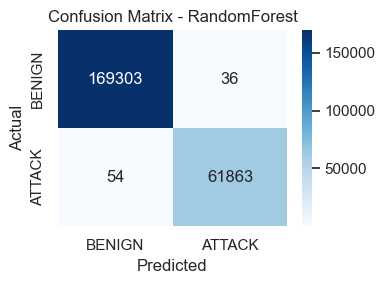


=== GradientBoosting ===
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    169339
      ATTACK       1.00      0.99      1.00     61917

    accuracy                           1.00    231256
   macro avg       1.00      1.00      1.00    231256
weighted avg       1.00      1.00      1.00    231256



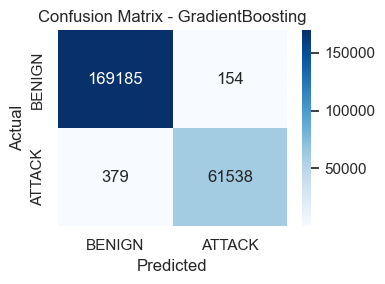


=== AdaBoost ===
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99    169339
      ATTACK       0.98      0.99      0.98     61917

    accuracy                           0.99    231256
   macro avg       0.99      0.99      0.99    231256
weighted avg       0.99      0.99      0.99    231256



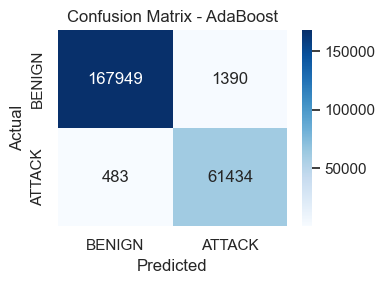


=== SVM ===


In [ ]:
results_matrix = []
results_reports=[]

for name, model in models.items():
    print(f"\n=== {name} ===")

    # Use selected, scaled features for all models
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)

    print(classification_report(y_test, y_pred, target_names=["BENIGN", "ATTACK"]))

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)

    results_matrix.append({
        "Model": name,
        "Accuracy": acc,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
    })

    #plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=["BENIGN", "ATTACK"],
        yticklabels=["BENIGN", "ATTACK"],
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    #plt.show()

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, average="macro") * 100
    rec = recall_score(y_test, y_pred, average="macro") * 100
    f1 = f1_score(y_test, y_pred, average="macro") * 100

    results_matrix.append({
        "Model": name,
        "Accuracy (%)": acc,
        "Precision (%)": prec,
        "Recall (%)": rec,
        "F1-Score (%)": f1
    })

results_df = pd.DataFrame(results_matrix)
results_df.sort_values(by="Accuracy", ascending=False)

results_df = pd.DataFrame(results_reports)
results_df.sort_values(by="Accuracy", ascending=False)

## 7. Voting Classifier (Ensemble of Strong Models)

We now build a soft VotingClassifier using a subset of the best-performing models to compare single vs ensemble performance.

=== Voting Classifier ===
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     33852
      ATTACK       1.00      0.99      1.00     12399

    accuracy                           1.00     46251
   macro avg       1.00      1.00      1.00     46251
weighted avg       1.00      1.00      1.00     46251



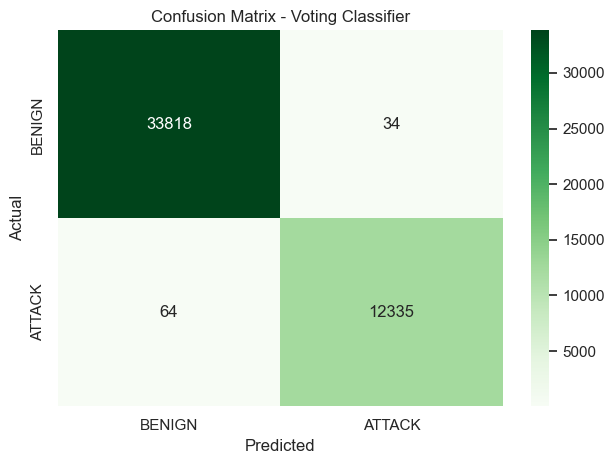

In [ ]:
estimators = []

if "LogisticRegression" in models:
    estimators.append(("lr", models["LogisticRegression"]))
if "RandomForest" in models:
    estimators.append(("rf", models["RandomForest"]))
if "GradientBoosting" in models:
    estimators.append(("gb", models["GradientBoosting"]))

voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
)

voting_clf.fit(X_train_sel, y_train)
y_pred_voting = voting_clf.predict(X_test_sel)

print("=== Voting Classifier ===")
print(classification_report(y_test, y_pred_voting, target_names=["BENIGN", "ATTACK"]))

cm_v = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(
    cm_v,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=["BENIGN", "ATTACK"],
    yticklabels=["BENIGN", "ATTACK"],
)
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis (Tree-Based Model)

Using the RandomForest model, we identify the most influential features contributing to attack detection.

In [ ]:
rf = models["RandomForest"]
importances = rf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": selected_features,
    "importance": importances,
}).sort_values(by="importance", ascending=False)

feat_imp.head(20)

,feature,importance
5,Bwd Packet Length Std,0.142916
0,Average Packet Size,0.085826
15,Packet Length Variance,0.074789
1,Avg Bwd Segment Size,0.074425
3,Bwd Packet Length Max,0.066754
14,Packet Length Std,0.065655
4,Bwd Packet Length Mean,0.061250
11,Max Packet Length,0.044608
6,Destination Port,0.044002
13,Packet Length Mean,0.040703


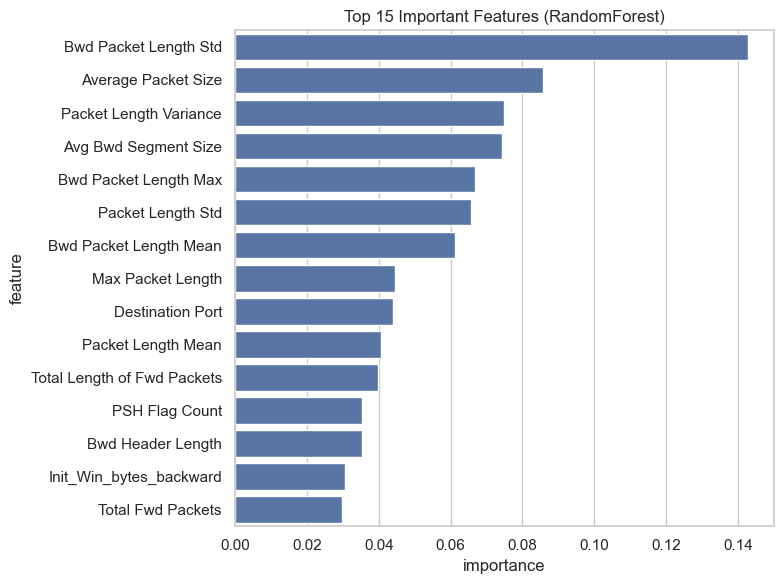

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(15))
plt.title("Top 15 Important Features (RandomForest)")
plt.tight_layout()
plt.show()

In [ ]:
# 1. pick a random row
sample = df.sample(1)

# 2. extract feature values
sample_features = sample[feature_cols]

# 3. scale
sample_scaled = scaler.transform(sample_features)
print (sample_features)
# 4. select RFE-features
sample_selected = sample_scaled[:, selected_mask]


# 5. predict (using best model)
pred = models["RandomForest"].predict(sample_selected)[0]

# 6. print human-readable result
actual = sample['Attack_Binary'].values[0]

print("=== Random Flow Prediction ===")
print("Actual Label     :", "ATTACK" if actual==1 else "BENIGN")
print("Predicted Label  :", "ATTACK" if pred==1 else "BENIGN")
print("\nFull row:")
sample


        ACK Flag Count  Active Max  Active Mean  Active Min  Active Std  \
286789               0           0          0.0           0         0.0   

        Average Packet Size  Avg Bwd Segment Size  Avg Fwd Segment Size  \
286789                 76.0                  64.0                  44.0   

        Bwd Avg Bulk Rate  Bwd Avg Bytes/Bulk  ...  Subflow Bwd Packets  \
286789                  0                   0  ...                    1   

        Subflow Fwd Bytes  Subflow Fwd Packets  Total Backward Packets  \
286789                 44                    1                       1   

        Total Fwd Packets  Total Length of Bwd Packets  \
286789                  1                           64   

        Total Length of Fwd Packets  URG Flag Count  act_data_pkt_fwd  \
286789                           44               0                 0   

        min_seg_size_forward  
286789                    32  

[1 rows x 78 columns]
=== Random Flow Prediction ===
Actual Label     :

C:\Users\DST\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,...,Subflow Fwd Bytes,Subflow Fwd Packets,Total Backward Packets,Total Fwd Packets,Total Length of Bwd Packets,Total Length of Fwd Packets,URG Flag Count,act_data_pkt_fwd,min_seg_size_forward,Attack_Binary
286789,0,0,0.0,0,0.0,76.0,64.0,44.0,0,0,...,44,1,1,1,64,44,0,0,32,0


## 9. Summary & Discussion (for your report)

Use this section (as Markdown) to summarize:

- Dataset description (CIC-IDS-2017 subsets merged: Monday, Wednesday, Friday PortScan, Friday DDoS)
- Preprocessing steps: cleaning, NaN handling, binary label mapping, scaling
- Feature selection: RFE + tree-based importance
- Model comparison: single models vs ensembles (VotingClassifier)
- Trade-offs: accuracy vs computational complexity (e.g., RF/XGBoost vs Logistic Regression)
- Key features driving performance (e.g., bytes/s, packets/s, IAT, flow duration)
- Limitations and future work (e.g., multiclass classification, deep learning, real-time deployment).